## Siamese Neural Networks

* A Siamese neural network (sometimes called a twin neural network) is an artificial neural network that uses the same weights while working in tandem on two different input vectors to compute comparable output vectors (wikipedia).

* Similarity has always been a key aspect in computer science and statistics. Any time two element vectors are compared, many different similarity approaches can be used, depending on the final goal of the comparison (Euclidean distance, Pearson correlation coefficient, Spearman’s rank correlation coefficient, and others). 

* But if the comparison has to be applied to more complex data samples, with features having different dimensionality and types which might need compression before processing, these measures would be unsuitable. In these cases, a siamese neural network may be the best choice. 

* it consists of two identical artificial neural networks each capable of learning the hidden representation of an input vector. The two neural networks are both feedforward perceptrons, and employ error back-propagation during training; they work parallelly in tandem and compare their outputs at the end, usually through a cosine distance. 

* The output generated by a siamese neural network execution can be considered the semantic similarity between the projected representation of the two input vectors. *(Chicco, Davide (2020), "Siamese neural networks: an overview", Artificial Neural Networks, Methods in Molecular Biology, vol. 2190 (3rd ed.), New York City, New York)*

* Uses of similarity measures where a twin network might be used are such things as recognizing handwritten checks, automatic detection of faces in camera images, and matching queries with indexed documents. 

* The perhaps most well-known application of twin networks are face recognition, where known images of people are precomputed and compared to an image from a turnstile or similar.

* Input: Given a pair of input images, we want to know how ``similar'' they are to each other. 

* Output: A real valued number indicating how similar a pair of images are.


![](https://miro.medium.com/max/1400/1*I7a9aVN2poHUtiHSq2q44Q.png)


![](https://d3i71xaburhd42.cloudfront.net/997dc5d9a058753f034422afe7bd0cc0b8ad808b/4-Figure1-1.png)

* Network architecture choice will be problem dependant 

### A variant of a SNS is the SNS with triplet loss

![](https://i.stack.imgur.com/cGHVs.png)

You need to provide a set of three images for each observation:

* Anchor (A)
* Positive (P) same class as the anchor
* Negative (N) different class as the anchor

In this case we make use of a triplet loss function. The idea is that we compute the distance between the anchor and the positive, and the distance between the anchor of the negative.

* So what we want is: d(A,P) <= d(A,N) this makes sense since we want the distance between the anchor and positive example to be very small (i.e. that they are similar).

* So we can say is that we want d(A,P) - d(A,N) <= 0 by rewriting the equation.

* One trivial solution to this equation is to set the terms on the left to 0.

* To overcome this, we can add a margin: d(A,P) - d(A,N) + margin <= 0

* triplet loss function:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/933c19129ec9060b0e7ea6f54f715c4c92010399)

* Remember, we want a small loss. So by taking the maximum this helps us optimise the network. If the term on the left is greater than zero, then we have a loss greater than 0. However if the term on the left is less than zero, then the maximum will be 0, and this is good.

* We want to pick pairs such that the distance between d(A,P) is closs enough to d(A,N) which will then force the network to learn how to better separate them. If we pick pairs randomly, it might be that the distances is already large, and thus not much learning (updating of weights) takes place.

![](https://miro.medium.com/max/1400/1*rDBbSTCvh0xnu2otaW9cyw.png)

Example below

![](https://miro.medium.com/max/1302/1*SKWGC3ehCbGCsbJVge6kmg.png)

* This study made the triplet loss function well known: FaceNet: A Unified Embedding for Face Recognition and Clustering by Florian Schroff, Dmitry Kalenichenko, James Philbin

### Contrastive loss

* Here only two images are considered

![](https://miro.medium.com/max/1400/1*M09N0GvSxNugENXv1MvDcA.png)

Partial code credits: https://www.kaggle.com/code/kmader/image-similarity-with-siamese-networks/notebook 



## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

### Download the data

This is an unsupervised problem so we don't need the labels

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


### Normalise the data

Divide by the maximum pixel value, 255.

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
x_train.shape

(60000, 28, 28)

### Reshape the data so that it has a 1 to indicate the depth of each image

In [ ]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [ ]:
x_train.shape

(60000, 28, 28, 1)

Group classes together

In [ ]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


Next we create a function which will create our dataset. What this function does is it takes the 10 groups as input, and then returns batches. The batches will contain 3 things 1) group A images 2) group B images 3) a similarity score. Here group A and B are unrelated to the 10 groups. 

Group A means images fed into the first branch of the SNN, and group B means images fed into the second branch of the SNN.

Note that this function is not what we wiill use to train the network. This is not an iterator like we saw in previous pracs.

In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):

    # We will store all group A images here
    out_img_a = []

    # All B images here
    out_img_b = [] 

    # The similarity score here
    out_score = []

    # Keep a list of all the groups (numbers 0 to 9 in our case)
    all_groups = list(range(len(in_groups)))

    # two iterations
    # In the first match_group is True, here we find matching pairs
    # In the second match_group is False, here we find different pairs
    for match_group in [True, False]:

        # Randomly select groups (this will be random numbers between 0 and 9)
        group_idx = np.random.choice(all_groups, size = batch_halfsize)

        # Randomly select an image from those groups
        # This is group A
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]

        # In the first iteration, we set group B to the same as group A
        if match_group:
            b_group_idx = group_idx

            # Set the corresponding target value to 1
            out_score += [1]*batch_halfsize

        # In the second iteration, we set group B to any other group from group A
        else:
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx

            # Set the corresponding target value to 0
            out_score += [0]*batch_halfsize
        
        # This is group B
        # We use the results from the if/else statement to select the corresponding image
        # either from the same group of different
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
          

    # Return group A images, group B images and the corresponding targets (0 or 1)
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

* Okay now let us look at some pairs. 

* On the top are images from group A, and on the bottom group B

* The corresponding similarity values are presented

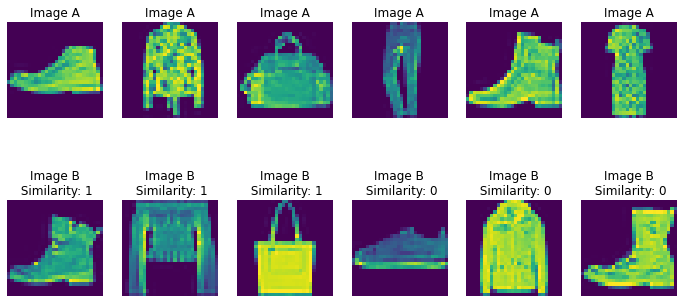

In [ ]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: ' + str(c_d))
    ax2.axis('off')

## Now we create the feature extractor

Note that the two feature extractors are the same. But we only need to create this once and we will re-use it twice later on when we combine the two together.

In this case the feature extractor will expect an input of (28,28,1) and output a vector of length 32. So our embedding will be of length 32 for each image.

In [ ]:
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

# Define the input
input = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')

# Now the conv, batch norm and pooling layers...
x = Conv2D(8, kernel_size = (3,3))(input)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(16, kernel_size = (3,3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D((2,2))(x)

x = Conv2D(16, kernel_size = (3,3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(32, kernel_size = (3,3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D((2,2))(x)

x = Flatten()(x)
x = Dense(32, activation = 'linear')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Activation('relu')(x)

Now we create the feature extractor

In [ ]:
feature_model = Model(inputs = [input], outputs = [output], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24,

## Now time to make the SNN

In [ ]:
# Input for images going into group A
sns_input_a = Input(shape = x_train.shape[1:], name = 'ImageA_Input')

# Input for images going into group B
sns_input_b = Input(shape = x_train.shape[1:], name = 'ImageB_Input')

# Get the embedding output for group A branch
embedding_a = feature_model(sns_input_a)

# Get the embedding output for group B branch
embedding_b = feature_model(sns_input_b)

# Combine the embeddings together
combined_features = concatenate([embedding_a, embedding_b], name = 'merge_features')

# Normal MLP layers next
combined_features = Dense(16)(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)

# The output here is represented as the sigmoid output
snn_output = Dense(1, activation = 'sigmoid')(combined_features)

In [ ]:
similarity_model = Model(inputs = [sns_input_a, sns_input_b], 
                         outputs = [snn_output], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          25040       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

In [ ]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

Here we write an iterator function which will yield the pairs of images from group A and group B along with the similarity score. Now we can work in batches, here size 32.

In [ ]:
def siam_gen(in_groups, batch_size = 32):

  while True:
    # Make use of our existing function to generate the images
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)

    # notice the format here: array, float
    # The array is due to the fact that we will input two input images
    # Remember: inputs = [sns_input_a, sns_input_b]
    yield [pv_a, pv_b], pv_sim

In [ ]:
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)

In [ ]:
loss_history = similarity_model.fit(siam_gen(train_groups),
                                      validation_data=([valid_a, valid_b], valid_sim),
                                      epochs = 10,
                                      steps_per_epoch=256, #Total number of steps (batches of samples) 
                                      # to yield from generator before declaring one epoch finished and starting the next epoch
                                      verbose = True)

Epoch 1/10
256/256 [==============================] - 23s 40ms/step - loss: 0.6900 - mae: 0.4809 - val_loss: 0.6231 - val_mae: 0.4522
Epoch 2/10
256/256 [==============================] - 10s 39ms/step - loss: 0.6159 - mae: 0.4443 - val_loss: 0.5670 - val_mae: 0.4154
Epoch 3/10
256/256 [==============================] - 11s 41ms/step - loss: 0.5639 - mae: 0.4079 - val_loss: 0.5024 - val_mae: 0.3543
Epoch 4/10
256/256 [==============================] - 10s 39ms/step - loss: 0.5041 - mae: 0.3578 - val_loss: 0.4248 - val_mae: 0.2944
Epoch 5/10
256/256 [==============================] - 10s 39ms/step - loss: 0.4572 - mae: 0.3153 - val_loss: 0.3982 - val_mae: 0.2626
Epoch 6/10
256/256 [==============================] - 9s 37ms/step - loss: 0.4375 - mae: 0.2970 - val_loss: 0.3931 - val_mae: 0.2442
Epoch 7/10
256/256 [==============================] - 9s 37ms/step - loss: 0.4312 - mae: 0.2901 - val_loss: 0.3894 - val_mae: 0.2439
Epoch 8/10
256/256 [==============================] - 10s 37ms/s

### Predicting

1/1 [==============================] - 0s 407ms/step


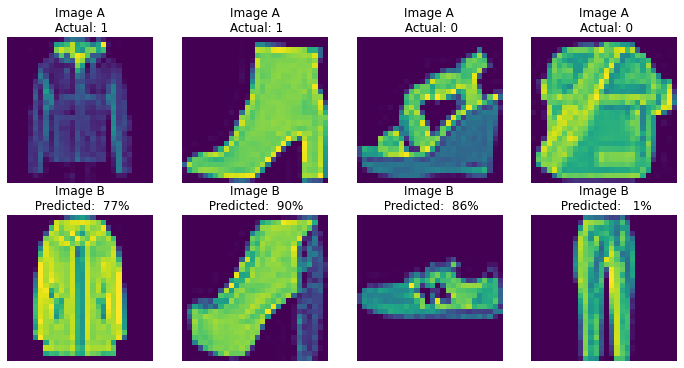

In [ ]:
# Greate a batch with 2 similar and 2 disimilar pairs from the test data
pv_a, pv_b, pv_sim = gen_random_batch(test_groups, 2)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))

# Predict the similarity between the pairs
pred_sim = similarity_model.predict([pv_a, pv_b])

# Iterate over each test image
for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
  ax1.imshow(c_a[:,:,0])
  ax1.set_title('Image A\n Actual: %i' % (c_d))
  ax1.axis('off')
  ax2.imshow(c_b[:,:,0])
  ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
  ax2.axis('off')

In [ ]:
pred_sim

array([[0.76501524],
       [0.8967914 ],
       [0.861289  ],
       [0.01253374]], dtype=float32)

### Computing similarity on a two single images (batch size of 1)

In [ ]:
similarity_model.predict([x_train[0, tf.newaxis], x_train[0, tf.newaxis]])

1/1 [==============================] - 0s 152ms/step


array([[0.88866186]], dtype=float32)